Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.000165 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [1.95e-01, 3.41e-03, 6.00e+00, 6.88e+00, 6.34e-02, 4.11e-02, 3.17e-01, 1.05e-03, 3.38e-01, 9.50e-02]    [1.85e-01, 1.86e-03, 6.04e+00, 6.81e+00, 6.80e-02, 4.11e-02, 3.17e-01, 1.05e-03, 3.38e-01, 9.50e-02]    []  
1000      [1.55e-05, 1.65e-05, 5.32e-05, 2.36e-05, 3.37e-05, 3.85e-06, 5.84e-06, 2.42e-05, 1.04e-05, 9.55e-06]    [1.08e-05, 1.01e-05, 3.23e-05, 1.86e-05, 2.52e-05, 3.85e-06, 5.84e-06, 2.42e-05, 1.04e-05, 9.55e-06]    []  
2000      [2.25e-06, 5.13e-06, 1.81e-05, 7.07e-06, 1.88e-05, 3.09e-07, 3.90e-06, 8.29e-06, 4.09e-06, 9.04e-06]    [9.86e-07, 2.52e-06, 1.15e-05, 4.79e-06, 1.53e-05, 3.09e-07, 3.90e-06, 8.29e-06, 4.09e-06, 9.04e-06]    []  
3000      [1.08e-06, 1.78e-06, 7.93e

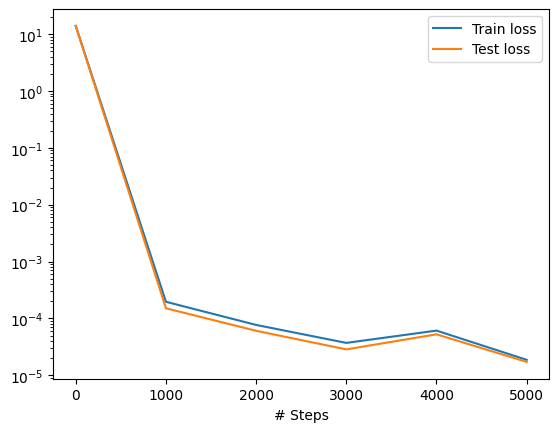

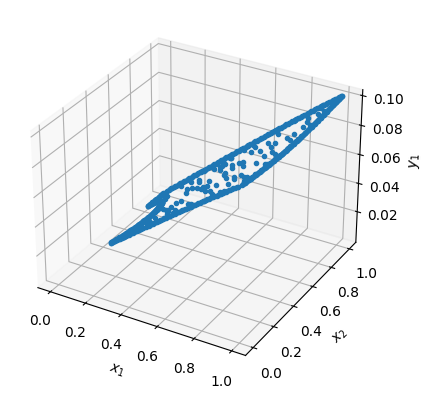

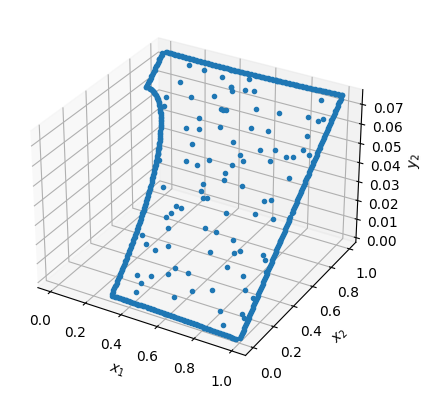

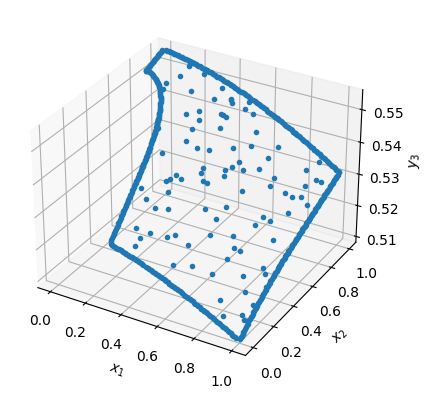

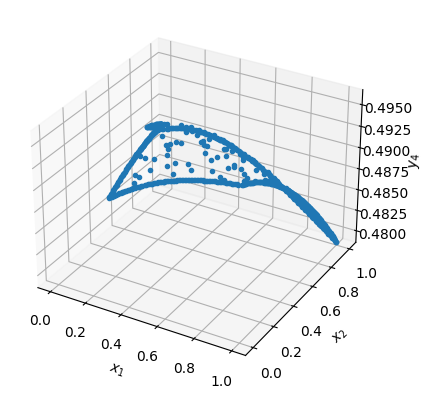

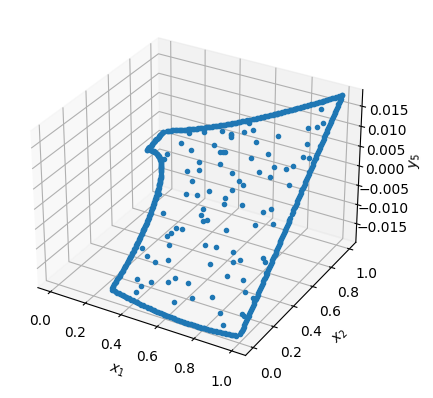

In [1]:
"""Backend supported: pytorch, paddle

Implementation of the linear elasticity 2D example in paper https://doi.org/10.1016/j.cma.2021.113741.
References:
    https://github.com/sciann/sciann-applications/blob/master/SciANN-Elasticity/Elasticity-Forward.ipynb.
"""
import deepxde as dde
import numpy as np
from global_constants import L, R, B0, EPS0, MU, LBD, RATIO

lmbd = LBD
mu = MU
Q = 4
Rx = 0.3
Ry = R**2 / Rx

# Define function
if dde.backend.backend_name == "pytorch":
    import torch

    sin = torch.sin
    cos = torch.cos


# Create the domain
rect = dde.geometry.Rectangle([0, 0], [L, L])
hole = dde.geometry.geometry_2d.Ellipse([0, 0], Ry, Rx, 0.5*np.pi)
geom = rect - hole



# Create Boundaries
def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], L)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)


def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], L)


def boundary_hole(x, on_boundary):
    return on_boundary and hole.on_boundary(x)




# Exact solutions
def func(x):
    ux = np.cos(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    uy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4

    E_xx = -2 * np.pi * np.sin(2 * np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])
    E_yy = np.sin(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 3
    E_xy = 0.5 * (
        np.pi * np.cos(2 * np.pi * x[:, 0:1]) * np.cos(np.pi * x[:, 1:2])
        + np.pi * np.cos(np.pi * x[:, 0:1]) * Q * x[:, 1:2] ** 4 / 4
    )

    Sxx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    Syy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    Sxy = 2 * E_xy * mu

    return np.hstack((ux, uy, Sxx, Syy, Sxy))


ux_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=0)
ux_right_bc = dde.icbc.DirichletBC(geom, lambda x: EPS0 * L, boundary_right, component=0)
uy_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
uy_top_bc = dde.icbc.DirichletBC(geom, lambda x: RATIO * EPS0 * L, boundary_top, component=1)
hole_bc = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_hole)
#alter code mit 5 outputs
#hole_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_hole, component=4)



# def fx(x):
#     return (
#         -lmbd
#         * (
#             4 * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
#             - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
#         )
#         - mu
#         * (
#             np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
#             - Q * x[:, 1:2] ** 3 * np.pi * cos(np.pi * x[:, 0:1])
#         )
#         - 8 * mu * np.pi**2 * cos(2 * np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])
#     )


# def fy(x):
#     return (
#         lmbd
#         * (
#             3 * Q * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
#             - 2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
#         )
#         - mu
#         * (
#             2 * np.pi**2 * cos(np.pi * x[:, 1:2]) * sin(2 * np.pi * x[:, 0:1])
#             + (Q * x[:, 1:2] ** 4 * np.pi**2 * sin(np.pi * x[:, 0:1])) / 4
#         )
#         + 6 * Q * mu * x[:, 1:2] ** 2 * sin(np.pi * x[:, 0:1])
#     )


def pde(x, f):
    E_xx = dde.grad.jacobian(f, x, i=0, j=0)
    E_yy = dde.grad.jacobian(f, x, i=1, j=1)
    E_xy = 0.5 * (dde.grad.jacobian(f, x, i=0, j=1) + dde.grad.jacobian(f, x, i=1, j=0))

    S_xx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    S_yy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    S_xy = E_xy * 2 * mu

    Sxx_x = dde.grad.jacobian(f, x, i=2, j=0)
    Syy_y = dde.grad.jacobian(f, x, i=3, j=1)
    Sxy_x = dde.grad.jacobian(f, x, i=4, j=0)
    Sxy_y = dde.grad.jacobian(f, x, i=4, j=1)

    momentum_x = Sxx_x + Sxy_y - B0
    momentum_y = Sxy_x + Syy_y 

    stress_x = S_xx - f[:, 2:3]
    stress_y = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]


data = dde.data.PDE(
    geom,
    pde,
    [
        ux_left_bc,
        ux_right_bc,
        uy_bottom_bc,
        uy_top_bc,
        hole_bc
    ],
    num_domain=500,
    num_boundary=500,
    solution=None,
    num_test=100,
)

layers = [2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.PFNN(layers, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)


(29, 2)
[[-0.8080246333443931, -0.07337347253171426], [-0.8230273160073883, -0.047035459059048504], [-0.8148456816987499, -0.06284135856416673], [-0.8099851167693309, -0.07051641465175099], [-0.7628441556608321, -0.12075477516423498], [-0.2682085423703562, -0.2840371761633046], [-0.7474948365243878, -0.13261293462657212], [-0.2896320752269777, -0.2812974913246881], [-0.34552034780323043, -0.2729977899678126], [-0.8101893064986415, -0.07021175170531245], [-0.43901014172873537, -0.25499451831662445], [-0.8218265978823036, -0.04968194012425968], [-0.8332423939953487, -0.00443190988372317], [-0.8226918930382736, -0.04778990654031031], [-0.7818749520723285, -0.1037874466788613], [-0.5210145277388755, -0.23413518424256688], [-0.34927886694250204, -0.2723772270119404], [-0.7781414501643639, -0.10736231418090181], [-0.8281297192603331, -0.033473442949346476], [-0.045737584178624564, -0.29954780304952666], [-0.49391069303092877, -0.24162857583352618], [-0.6182642571859747, -0.20114748408543728]

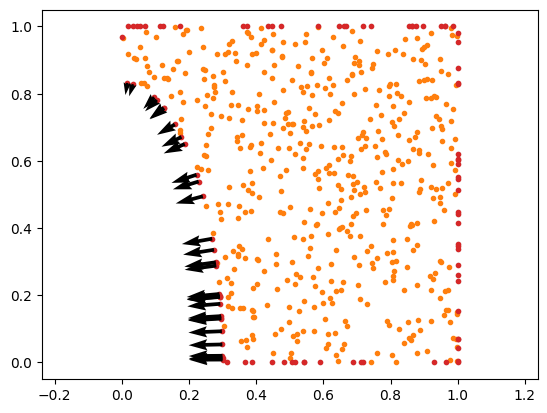

In [2]:
import matplotlib.pyplot as plt
from plotly.express.colors import sequential
import plotly.graph_objects as go
import plotly.figure_factory as ff

def boundary_normal(x):
    theta = np.arctan2(x[1]/Ry, x[0]/Rx)
    nx = Ry * np.cos(theta)
    ny = Rx * np.sin(theta)
    return [-nx, -ny]

def boundary_normal2(x):
    nx=(x[0])*Ry/Rx
    ny=(x[1])*Rx/Ry
    return [-nx, -ny]


# old code -> can be deleted
# phi = np.linspace(0, 0.5 * np.pi, int(25 * np.pi * Rx / L))

# print(Rx)
# hole = dde.geometry.geometry_2d.Ellipse([0, 0], Ry, Rx, 0.5*np.pi)
# xxxx = hole.random_boundary_points(50)


# print(boundary_normal(xxxx[0]))
# print("ssss")
# print(boundary_normal2(xxxx[0]))
# z = boundary_normal(xxxx[0])
# zzz = []
# for i in range(0,len(xxxx),1):
#     zzz.append(boundary_normal(xxxx[i]))



# plt.scatter(xxxx[:,0], xxxx[:,1], marker=".", color="#C9C5BC")
# plt.quiver(xxxx[:,0], xxxx[:,1], zzz[0::2], zzz[1::2], color="black")
# plt.axis("equal")
# plt.show()

outer_figure = geom.random_boundary_points(100)
inner_figure = geom.random_points(500)

def return_boundary_points(boundary_points, boundary_func):
    y = []
    for x in boundary_points:
        if boundary_func(x, True) == True:
                y.append(x)
    specific_boundary_points = np.expand_dims(y, axis=1)
    return specific_boundary_points

top_boundary = return_boundary_points(outer_figure, boundary_top)
left_boundary = return_boundary_points(outer_figure, boundary_left)
right_boundary = return_boundary_points(outer_figure, boundary_right)
bottom_boundary = return_boundary_points(outer_figure, boundary_bottom)
hole_boundary = return_boundary_points(outer_figure, boundary_hole)
hole_n = [boundary_normal(x) for x  in hole_boundary[:,0]]

print(np.shape(hole_n))
print(hole_n)
print(list(zip(*hole_n))[0])
print(np.shape(hole_boundary[:,0,0]))

plt.scatter(outer_figure[:,0], outer_figure[:,1], marker=".", color="#C9C5BC")
plt.scatter(inner_figure[:,0], inner_figure[:,1], marker=".", color="#ff7f0e")
plt.scatter(top_boundary[:,:,0], top_boundary[:,:,1], marker=".", color="#d62728")
plt.scatter(right_boundary[:,:,0], right_boundary[:,:,1], marker=".", color="#d62728")
plt.scatter(left_boundary[:,:,0], left_boundary[:,:,1], marker=".", color="#d62728")
plt.scatter(bottom_boundary[:,:,0], bottom_boundary[:,:,1], marker=".", color="#d62728")
plt.scatter(hole_boundary[:,:,0], hole_boundary[:,:,1], marker=".", color="#d62728")
plt.quiver(hole_boundary[:,0,0], hole_boundary[:,0,1], [sublist[0] for sublist in hole_n], [sublist[1] for sublist in hole_n], color="black")
plt.axis("equal")
plt.show()


mode = "markers"
gray = dict(color="#C9C5BC")
green = dict(color="#006561")
black = dict(color="black")
#fig = ff.create_quiver(hole[:, 0], hole[:, 1], n_hole[:, 0], n_hole[:, 1], marker=black)
fig = go.Figure()
fig.add_trace(go.Scatter(x=inner_figure[:, 0], y=inner_figure[:, 1], mode=mode, marker=gray))
fig.add_trace(go.Scatter(x=outer_figure[:,0], y=outer_figure[:,1], mode=mode, marker=green))
# fig.add_trace(go.Scatter(x=top_boundary[:,:,0], y=top_boundary[:,:,1], mode=mode, marker=green))
# fig.add_trace(go.Scatter(x=bottom_boundary[:,:,0], y=bottom_boundary[:,:,1], mode=mode, marker=green))
# fig.add_trace(go.Scatter(x=left_boundary[:,:,0], y=left_boundary[:,:,1], mode=mode, marker=green))
# fig.add_trace(go.Scatter(x=right_boundary[:,:,0], y=right_boundary[:,:,1], mode=mode, marker=green))
# fig.add_trace(go.Scatter(x=hole_boundary[:,:,0], y=hole_boundary[:,:,1], mode=mode, marker=black))
fig.layout.yaxis.scaleanchor = "x"
fig.update_layout(
    template="none",
    width=400,
    height=400,
    margin=dict(l=0, r=0, b=0, t=0),
    showlegend=False,
)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()




In [1]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_domain = np.vstack([val_x.ravel(), val_y.ravel()]).T
mask = (
    ((val_domain[:, 0] ** 2) / (Rx**2)) + ((val_domain[:, 1] ** 2) / (Ry**2))
) > 1
val = val_domain[mask]

# Compute model predictions on the validation domain
results = model.predict(val)
disp = results[:, 0:2]
def_val = val + disp
mises = np.sqrt(
    results[:, 2] ** 2
    + results[:, 4] ** 2
    - results[:, 2] * results[:, 4]
    + 3 * results[:, 3] ** 2
)

def make_plot(x, y, variable, title, cmap=sequential.Viridis, size=8.0):
    fig = go.Figure()

    # Plot boundaries
    m = dict(color="black")
    fig.add_trace(go.Scatter(x=outer_figure[:,0], y=outer_figure[:,1], marker=m))
    # fig.add_trace(go.Scatter(x=top_boundary[:,:, 0], y=top_boundary[:,:, 1], mode="lines", marker=m))
    # fig.add_trace(go.Scatter(x=bottom_boundary[:,:, 0], y=bottom_boundary[:,:, 0], mode="lines", marker=m))
    # fig.add_trace(go.Scatter(x=left_boundary[:,:, 0], y=left_boundary[:,:, 0], mode="lines", marker=m))
    # fig.add_trace(go.Scatter(x=right_boundary[:,:, 0], y=right_boundary[:,:, 0], mode="lines", marker=m))
    # fig.add_trace(go.Scatter(x=hole_boundary[:,:, 0], y=hole_boundary[:,:, 0], mode="lines", marker=m))

    # Plot variable values
    m = dict(color=variable, colorscale=cmap, size=size, colorbar=dict(thickness=10))
    fig.add_trace(go.Scatter(x=x, y=y, marker=m, mode="markers"))

    # plot settings
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none", width=400, height=400, title=title, showlegend=False
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()

# Plot stresses
make_plot(*def_val.T, results[:, 2], "Stress xx")
make_plot(*def_val.T, results[:, 3], "Stress xy")
make_plot(*def_val.T, results[:, 4], "Stress yy")
make_plot(*def_val.T, mises, "Mises stress")

# Plot displacements
make_plot(*def_val.T, disp[:, 0], "Displacement in x", cmap=sequential.Inferno)
make_plot(*def_val.T, disp[:, 1], "Displacement in y", cmap=sequential.Inferno)



NameError: name 'np' is not defined